# Improving Bank Marketing Campaigns with Machine Learning
### Group 7 - Gary Bair, Hunter Blum, Jacqueline Urenda

### Package Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Sklearn packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV


#pipeline tools
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

#resampling tools
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

#feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier

#metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

#pandas settings
pd.set_option('display.max_columns', None)

# DMBA packages
from dmba import gainsChart, liftChart

# Dataset Description

The data used in this analysis is related to the direct marketing campaigns of a Portuguese banking institution and is based on phone marketing calls to determine whether a customer would subscribe to the banks term deposit subscription with more than one contact often being required. The full dataset is comprised of 41,188 records and 20 predictive features ordered by date from May 2008 to November 2010.

### *Input variables*:
1. age: Customer Age (numeric)
2. job : Type of Job (categorical)
3. marital : Marital Status (categorical)
4. education: Level of Education (categorical)
5. default: Has credit in default? (categorical)
6. housing: Has housing loan? (categorical)
7. loan: Has personal loan? (categorical)
8. contact: Contact Communication Type (categorical)
9. month: Last Contact Month of Year (categorical)
10. day_of_week: Last Contact Day of the Week (categorical)
11. duration: Last Contact Duration, in seconds (numeric). 
12. campaign: Number of contacts performed during this campaign and for this client which includes last contact(numeric)
13. pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
14. previous: Number of contacts performed before this campaign and for this client (numeric)
15. poutcome: Outcome of previous marketing campaign contacts (categorical)
16. emp.var.rate: Employment Variation Rate - quarterly indicator (numeric)
17. cons.price.idx: Consumer Price Index - monthly indicator (numeric)
18. cons.conf.idx: Consumer Confidence Index - monthly indicator (numeric)
19. euribor3m: Euribor 3 Month Rate - daily indicator (numeric)
20. nr.employed: Number of Employees - quarterly indicator (numeric)

### *Output Variable*:
21. y - has the client subscribed a term deposit? (binary)

There are two significant things to note from the description of the data.
- The duration feature is highly affected by the output target (e.g., if duration=0 then y='no') therefore this feature should be discarded if the intention is to produce a realistic predictive model.
- For the feature pdays, 999 means client was not previously contacted which depending on the model implemented may affect the implementation of this analysis’s preprocessing.

# Data Import

In [2]:
bank = pd.read_csv("bank-additional-full.csv", delimiter=";")
bank.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

# Exploratory Data Analysis

### Univariate Analysis

In [3]:
# dataset dimensions
print("The data has", bank.shape[1], "features.")
print("The data has", bank.shape[0], "observations.")

The data has 21 features.
The data has 41188 observations.


In [4]:
# feature datatypes
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
# counts of unique labels
bank.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [6]:
# missing data
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

After partitioning by each feature, explicit missing data is not present thus imputation will not be required.

In [7]:
# descriptive stats:
bank.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

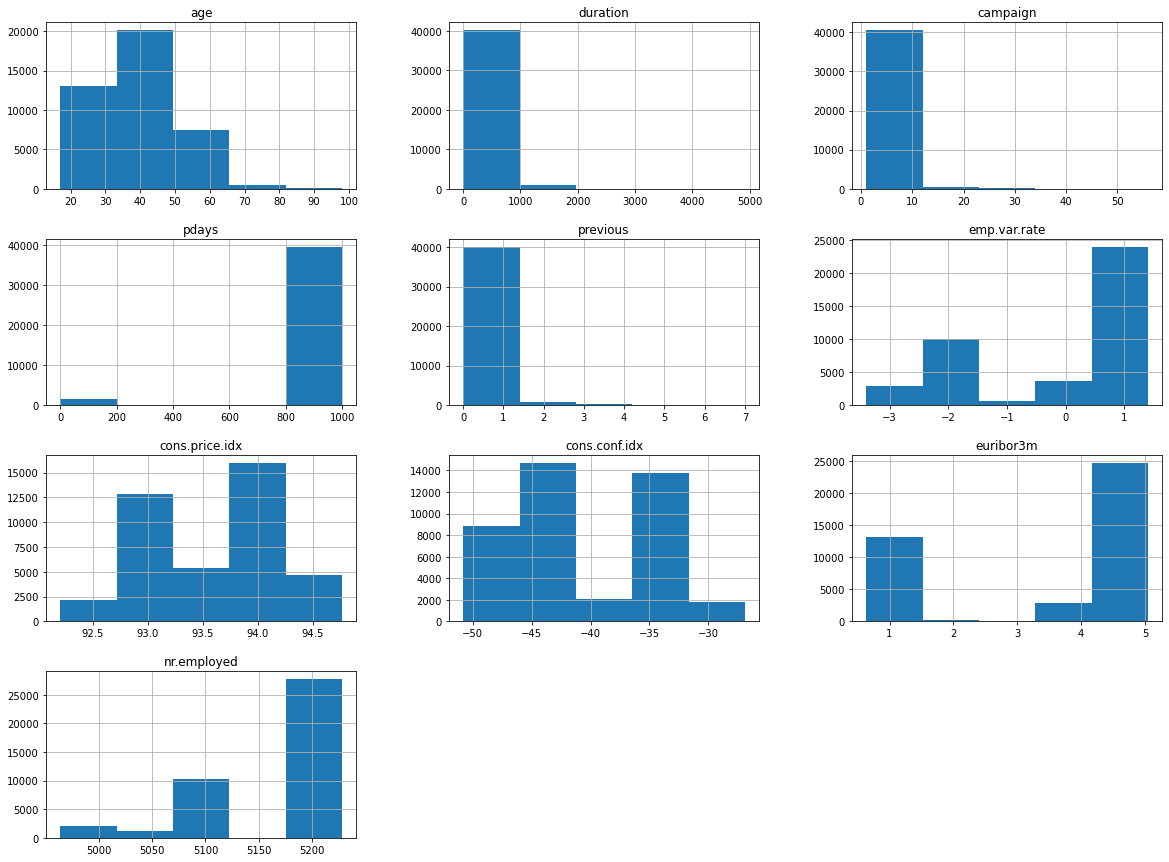

In [8]:
# distribution of numerical features
bank.hist(figsize=(20,15),bins=5)
plt.show()

"Age" seems most normally distributed but still appears to be right skewed. "Duration", "Campaign", and "previous" variables seem very rightly skewed. "pdays", "emp.var.rate", and "nr.employed" are heavily left skewed. Several variables don't have a normal distribution.

In [9]:
# calculating the skewness of numeric features
bank.skew()

age               0.784697
duration          3.263141
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

"Duration", "campaign", "pdays" and "previous" have the most skewness

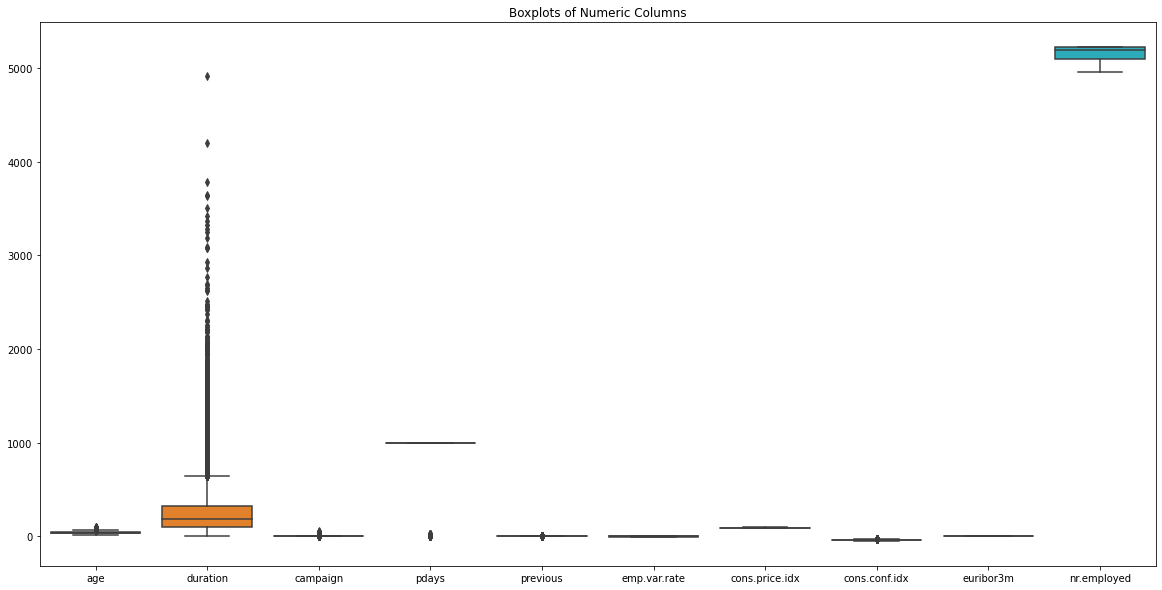

In [10]:
# outlier analysis
plt.figure(figsize=(20,10))
sns.boxplot(data = bank);
plt.title('Boxplots of Numeric Columns')
plt.show()

Boxplots show outliers in "duration", "campaign", "pdays", "previous" and "con.price.idx"

Text(0.5, 1.0, 'Distribution of Term Deposits')

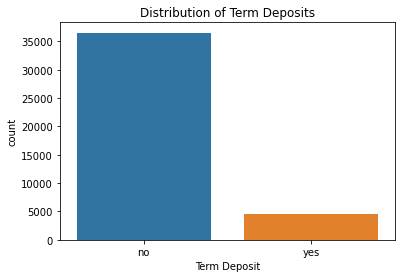

In [11]:
# distribution of target labels
sns.countplot(bank['y'])
plt.xlabel("Term Deposit")
plt.title("Distribution of Term Deposits")

In [12]:
y_count = bank.groupby(['y'])['y'].count()
yes_per = round(y_count.yes/bank.shape[0]*100,2)
no_per = round(y_count.no/bank.shape[0]*100,2)

print(y_count.yes, "(" + str(yes_per) + "%)", "of observations responded yes to a term deposit")
print(y_count.no, "(" + str(no_per) + "%)", "of observations responded no to a term deposit")


4640 (11.27%) of observations responded yes to a term deposit
36548 (88.73%) of observations responded no to a term deposit


Based on the distribution target labels, the directing marketing calls observe a default success rate

### Bivariate Analysis & Feature Selection
For the purpose of exploring the bivariate relationships between predictive features, categorical variables will be one-hot encoded. Findings will not be directly implemented on the working dataframe since this analysis will opt to implement these findings in pipeline.

In this application, the target variable has been re-encoded as y_yes

In [13]:
bank_cat = bank.select_dtypes('object')
bank_num = bank.select_dtypes(['float64', 'int64'])
OH_encoder = OneHotEncoder(drop = 'first', sparse=False)
bank_coded = OH_encoder.fit_transform(bank_cat)
bank_coded = pd.DataFrame(bank_coded, columns = OH_encoder.get_feature_names_out())
bank_coded = pd.concat([bank_coded, bank_num], axis = 1)
bank_coded.head()

job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0              0.0               0.0            1.0             0.0   
1              0.0               0.0            0.0             0.0   
2              0.0               0.0            0.0             0.0   
3              0.0               0.0            0.0             0.0   
4              0.0               0.0            0.0             0.0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0          0.0                0.0           0.0          0.0             0.0   
1          0.0                0.0           1.0          0.0             0.0   
2          0.0                0.0           1.0          0.0             0.0   
3          0.0                0.0           0.0          0.0             0.0   
4          0.0                0.0           1.0          0.0             0.0   

   job_unemployed  job_unknown  marital_married  marital_single  \
0             0.0          0.0              1.0             0.0   
1             0.0          0.0              1.0             0.0   
2             0.0          0.0              1.0             0.0   
3             0.0          0.0              1.0             0.0   
4             0.0          0.0              1.0             0.0   

   marital_unknown  education_basic.6y  education_basic.9y  \
0              0.0                 0.0                 0.0   
1              0.0                 0.0                 0.0   
2              0.0                 0.0                 0.0   
3              0.0                 1.0                 0.0   
4              0.0                 0.0                 0.0   

   education_high.school  education_illiterate  education_professional.course  \
0                    0.0                   0.0                            0.0   
1                    1.0                   0.0                            0.0   
2                    1.0                   0.0                            0.0   
3                    0.0                   0.0                            0.0   
4                    1.0                   0.0                            0.0   

   education_university.degree  education_unknown  default_unknown  \
0                          0.0                0.0              0.0   
1                          0.0                0.0              1.0   
2                          0.0                0.0              0.0   
3                          0.0                0.0              0.0   
4                          0.0                0.0              0.0   

   default_yes  housing_unknown  housing_yes  loan_unknown  loan_yes  \
0          0.0              0.0          0.0           0.0       0.0   
1          0.0              0.0          0.0           0.0       0.0   
2          0.0              0.0          1.0           0.0       0.0   
3          0.0              0.0          0.0           0.0       0.0   
4          0.0              0.0          0.0           0.0       1.0   

   contact_telephone  month_aug  month_dec  month_jul  month_jun  month_mar  \
0                1.0        0.0        0.0        0.0        0.0        0.0   
1                1.0        0.0        0.0        0.0        0.0        0.0   
2                1.0        0.0        0.0        0.0        0.0        0.0   
3                1.0        0.0        0.0        0.0        0.0        0.0   
4                1.0        0.0        0.0        0.0        0.0        0.0   

   month_may  month_nov  month_oct  month_sep  day_of_week_mon  \
0        1.0        0.0        0.0        0.0              1.0   
1        1.0        0.0        0.0        0.0              1.0   
2        1.0        0.0        0.0        0.0              1.0   
3        1.0        0.0        0.0        0.0              1.0   
4        1.0        0.0        0.0        0.0              1.0   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  poutcome_nonexistent  \
0              0.0          

### Near Zero Variance Analysis

In [14]:
X = bank_coded.drop(columns = ['y_yes'])
y = bank_coded['y_yes']
low_var = VarianceThreshold(threshold=0.1)
low_var.fit(X)
dropcols = [column for column in X.columns
           if column not in
X.columns[low_var.get_support()]]
for features in dropcols:
    print(features)
    
X_highvar = X.drop(dropcols, axis = 1)

job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_unemployed
job_unknown
marital_unknown
education_basic.6y
education_illiterate
education_unknown
default_yes
housing_unknown
loan_unknown
month_dec
month_mar
month_nov
month_oct
month_sep
poutcome_success


Interestingly, many of labels for occupation have very little representation. A similiar situation is noted for the labels of the feature month.

### Multicollinearity Analysis

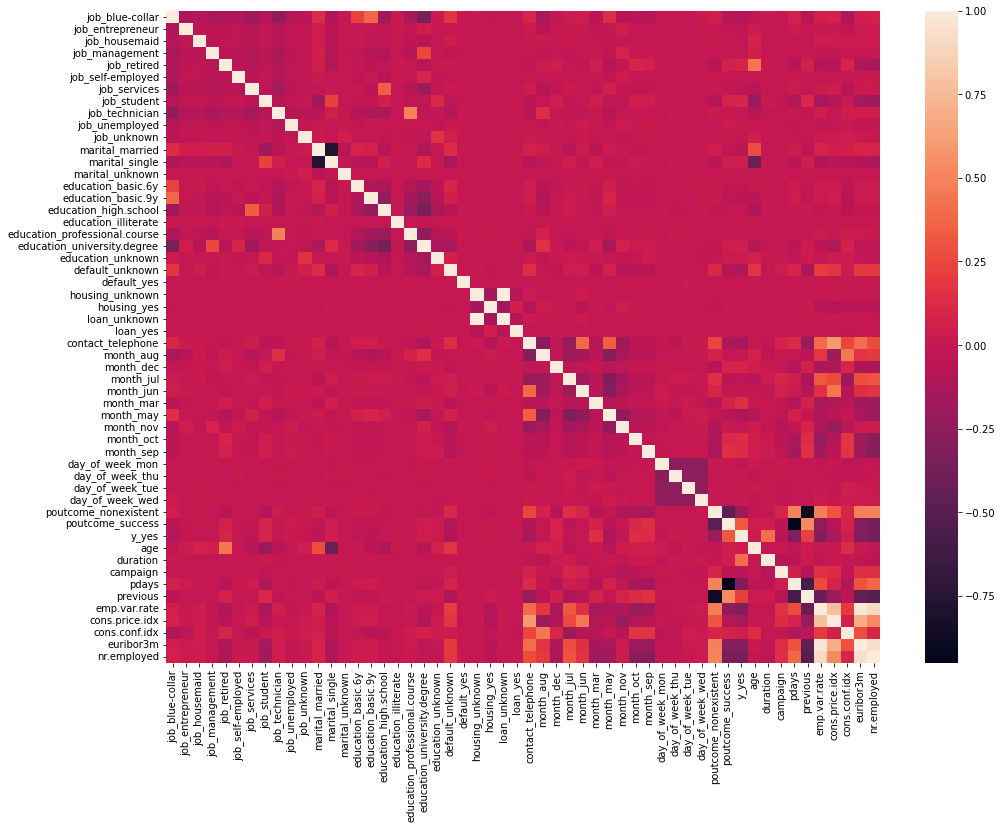

In [15]:
plt.figure(figsize = (16,12))
sns.heatmap(bank_coded.corr())
plt.show()

In [16]:
X_vif = pd.DataFrame()
X_vif['variable'] = X_highvar.columns
X_vif['vif'] = [variance_inflation_factor(X_highvar.values, i)
               for i in range(len(X_highvar.columns))]
# housing_no and loan_no were perfectly correlated with their counterparts so we'll remove them
X_clean = X_highvar #.drop(columns = ['housing_no', 'loan_no'])
X_vif = pd.DataFrame()
X_vif['variable'] = X_clean.columns
X_vif['vif'] = [variance_inflation_factor(X_clean.values, i)
               for i in range(len(X_clean.columns))]
drop = list(X_vif[X_vif['vif']>10].variable)
drop

['poutcome_nonexistent',
 'age',
 'pdays',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

Features of note flagged by VIF analysis include 'age', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', and 'nr.employed'. Modeling using this reduced feature set significantly impacted predictive performance

## Modeling

Given that this analysis uses pipelines to validate the sub components, all that's necessary in terms of explicit data preparation is partitioning the data into train and test splits, resampling the training set and specifying features into their respective categories for column transformations.

### Data Preparation

In [17]:
# specifying predictive and target features
X = bank.drop(columns = ['y'])
y = bank[['y']]

# encoding target feature labels as 0's and 1's
oe = OrdinalEncoder()
y = oe.fit_transform(y)

In [18]:
# column names
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [19]:
# creating train/test split where test represents the out of sample performance used
# to approximate real world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

# resampling training set using undersampling
undersampler = RandomUnderSampler(random_state = 123)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [20]:
# categorical features to be used in modeling
cat_variables = ['job', 
                 'marital', 
                 'education', 
                 'default', 
                 'housing', 
                 'loan', 
                 'contact', 
                 'month', 
                 'day_of_week', 
                 'poutcome']
# numeric features to be used in modeling
num_variables = ['age',
                 #'duration', this feature is removed since feature cannot be determined before contact
                 'campaign',
                 'pdays',
                 'previous',
                 'emp.var.rate', 
                 'cons.conf.idx', 
                 'euribor3m', 
                 'nr.employed']

### k-Nearest Neighbors

MinMaxScaler is specifically used to ensure that features have same scale when computing distances.

In [26]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', MinMaxScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('knn', KNeighborsClassifier(n_jobs = 4))])

In [27]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': list(range(1,26,2))}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

knn = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 500,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = 4)
knn.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % knn.best_score_)
print(knn.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.05, 'knn__weights': 'distance', 'knn__n_neighbors': 7, 'k_best__k': 20}


In [28]:
knn_y_pred = knn.predict(X_test)
knn_y_proba = knn.predict_proba(X_test)

In [29]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      7298
         1.0       0.35      0.86      0.50       940

    accuracy                           0.81      8238
   macro avg       0.67      0.83      0.69      8238
weighted avg       0.91      0.81      0.84      8238



In [30]:
data = [accuracy_score(y_test, knn_y_pred, normalize=True), 
        precision_score(y_test, knn_y_pred),
        recall_score(y_test, knn_y_pred),
        fbeta_score(y_test, knn_y_pred, beta=1),
        roc_auc_score(y_test, knn_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table = pd.DataFrame(data,
                          index = test_names,
                          columns = ['k-NN'])

### Experiment: Validating Resampling Value 

In [105]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

neighbors = list(range(1,26,2))
weight = ['uniform', 'distance']

params = dict(knn__n_neighbors = neighbors,
             knn__weights = weight)

knn_pipe = Pipeline(steps = [('scaler', scaler), ('knn', knn)])

#### Unbalanced

In [106]:
knn_tuned = GridSearchCV(knn_pipe, params, n_jobs = -1)
knn_tuned.fit(X_train, y_train)
knn_reg_pred = knn_tuned.predict(X_test)
print(knn_tuned.best_params_)
print(classification_report(y_test, knn_reg_pred))

{'knn__n_neighbors': 25, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      7298
         1.0       0.68      0.28      0.40       940

    accuracy                           0.90      8238
   macro avg       0.80      0.63      0.67      8238
weighted avg       0.89      0.90      0.88      8238



#### Balanced - A lot better recall, but precision took a big hit.

In [108]:
knn_baltuned = GridSearchCV(knn_pipe, params, n_jobs = -1)
knn_baltuned.fit(X_under, y_under)
knn_bal_pred = knn_baltuned.predict(X_test)
print(knn_baltuned.best_params_)
print(classification_report(y_test, knn_bal_pred))

{'knn__n_neighbors': 25, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      7298
         1.0       0.41      0.71      0.52       940

    accuracy                           0.85      8238
   macro avg       0.68      0.79      0.71      8238
weighted avg       0.90      0.85      0.86      8238



### Neural Networks

In [31]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'drop')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('mlp', MLPClassifier(solver = 'sgd'))])

In [32]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'mlp__hidden_layer_sizes': [(10,30,10), (20,)],
                 'mlp__activation': ['relu', 'logistic', 'tanh'], 
                 'mlp__alpha': [0.0001, 0.001, 0.01, 0.1], 
                 'mlp__learning_rate': ['constant', 'adaptive']}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

mlp = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = 4)
mlp.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % mlp.best_score_)
print(mlp.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.05, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (10, 30, 10), 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh', 'k_best__k': 8}


In [33]:
mlp_y_pred = mlp.predict(X_test)
mlp_y_proba = mlp.predict_proba(X_test)

In [34]:
print(classification_report(y_test, mlp_y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.78      0.86      7298
         1.0       0.29      0.68      0.40       940

    accuracy                           0.77      8238
   macro avg       0.62      0.73      0.63      8238
weighted avg       0.87      0.77      0.81      8238



In [35]:
data = [accuracy_score(y_test, mlp_y_pred, normalize=True), 
        precision_score(y_test, mlp_y_pred),
        recall_score(y_test, mlp_y_pred),
        fbeta_score(y_test, mlp_y_pred, beta=1),
        roc_auc_score(y_test, mlp_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['Neural Net'] = data

### XGBoost
Note: You need an NVIDIA GPU to train this model with the gpu_hist option.

In [36]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)],
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('xgBoost', xgb.XGBClassifier(objective="binary:logistic",
                                                        tree_method = 'gpu_hist'))])

In [37]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'xgBoost__n_estimators': [50, 100, 150, 200, 250, 300],
                 'xgBoost__learning_rate': [0.01, 0.1, 0.3, .05, 1],
                 'xgBoost__max_depth': range(3,21,2),
                 'xgBoost__colsample_bytree': [i/10.0 for i in range(3,10)],
                 'xgBoost__gamma': [i/10.0 for i in range(5)],
                 'xgBoost__reg_alpha' : [1e-5, 1e-2, 0.1, .3],
                 'xgBoost__reg_lambda' : [1e-5, 1e-2, 0.1,.3]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

xgb = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space, 
                         n_iter = 500, 
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = 4)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

Best parameter (CV score=nan):
{'xgBoost__reg_lambda': 0.01, 'xgBoost__reg_alpha': 0.3, 'xgBoost__n_estimators': 200, 'xgBoost__max_depth': 11, 'xgBoost__learning_rate': 1, 'xgBoost__gamma': 0.0, 'xgBoost__colsample_bytree': 0.8, 'nzv__threshold': 0.1, 'k_best__k': 3}


In [38]:
xgb_y_pred = xgb.predict(X_test)
xgb_y_proba = xgb.predict_proba(X_test)

In [39]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90      7298
         1.0       0.41      0.88      0.56       940

    accuracy                           0.84      8238
   macro avg       0.70      0.86      0.73      8238
weighted avg       0.92      0.84      0.87      8238



In [40]:
data = [accuracy_score(y_test, xgb_y_pred, normalize=True), 
        precision_score(y_test, xgb_y_pred),
        recall_score(y_test, xgb_y_pred),
        fbeta_score(y_test, xgb_y_pred, beta=1),
        roc_auc_score(y_test, xgb_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['XGBoost'] = data

### Experiments: Validating Preprocessing Steps

In [38]:
#model performance without duration and nzv and vif reduced
xgb_pred = search.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      7298
         1.0       0.17      0.63      0.27       940

    accuracy                           0.62      8238
   macro avg       0.55      0.62      0.51      8238
weighted avg       0.84      0.62      0.69      8238



In [9]:
#model performance without duration and nzv
xgb_pred = search.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      7298
         1.0       0.44      0.89      0.59       940

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.88      8238



In [73]:
#model performance without duration 
xgb_pred = search.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      7298
         1.0       0.43      0.90      0.58       940

    accuracy                           0.85      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.85      0.87      8238



In [72]:
#model performance with duration included
xgb_pred = search.predict(X_test)
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      7298
         1.0       0.43      0.92      0.59       940

    accuracy                           0.85      8238
   macro avg       0.71      0.88      0.75      8238
weighted avg       0.93      0.85      0.87      8238



### Extra Trees

In [41]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], 
                                                                   remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('etc', ExtraTreesClassifier())])

In [42]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'etc__n_estimators': [10, 50, 100, 500, 1000, 5000],
                 'etc__max_leaf_nodes': [5, 10, 15, 20, 25, 50], 
                 'etc__max_depth': range(2,21,1)}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

etc = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         scoring ='recall',
                         n_jobs = 4)
etc.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % etc.best_score_)
print(etc.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.0, 'k_best__k': 8, 'etc__n_estimators': 1000, 'etc__max_leaf_nodes': 5, 'etc__max_depth': 2}


In [43]:
etc_y_pred = etc.predict(X_test)
etc_y_proba = etc.predict_proba(X_test)

In [44]:
print(classification_report(y_test, etc_y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81      7298
         1.0       0.24      0.72      0.36       940

    accuracy                           0.71      8238
   macro avg       0.60      0.71      0.59      8238
weighted avg       0.87      0.71      0.76      8238



In [45]:
data = [accuracy_score(y_test, etc_y_pred, normalize=True), 
        precision_score(y_test, etc_y_pred),
        recall_score(y_test, etc_y_pred),
        fbeta_score(y_test, etc_y_pred, beta=1),
        roc_auc_score(y_test, etc_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['ExtraTrees'] = data

### Logistic Regression

In [46]:
# Categorical pipeline
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(strategy="constant", fill_value='Unknown')),
                     ('cat_encoder', OneHotEncoder())])

# Numerical pipeline:
num_pipe = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                     ('num_scaler', StandardScaler())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables),
                                                                    ('num', num_pipe, num_variables)], remainder = 'passthrough')),
                          ('nzv', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('logreg', LogisticRegression(solver = 'saga'))])

In [47]:
search_space = [{'nzv__threshold': [0.00, 0.01, 0.05, .10],
                 'k_best__k': list(range(1,26,1)),
                 'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                 'logreg__C': [0.01, 0.1, 0.3, .05, 1]}]

kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=123)

lr = RandomizedSearchCV(full_pipeline,
                        param_distributions = search_space,
                        n_iter = 200,
                        cv = kfold,
                        scoring ='recall',
                        n_jobs = 4)
lr.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lr.best_score_)
print(lr.best_params_)

Best parameter (CV score=nan):
{'nzv__threshold': 0.05, 'logreg__penalty': 'l2', 'logreg__C': 0.3, 'k_best__k': 23}


In [48]:
lr_y_pred = lr.predict(X_test)
lr_y_proba = lr.predict_proba(X_test)

In [49]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89      7298
         1.0       0.33      0.64      0.43       940

    accuracy                           0.81      8238
   macro avg       0.64      0.73      0.66      8238
weighted avg       0.88      0.81      0.83      8238



In [50]:
data = [accuracy_score(y_test, lr_y_pred, normalize=True), 
        precision_score(y_test, lr_y_pred),
        recall_score(y_test, lr_y_pred),
        fbeta_score(y_test, lr_y_pred, beta=1),
        roc_auc_score(y_test, lr_y_pred)]

test_names = ['Accuracy',
              'Precision',
              'Recall',
              'F1',
              'AUC ROC']

test_table['Logistic Regression'] = data

## Results
Create Results Dataframe

In [51]:
test_table

k-NN  Neural Net   XGBoost  ExtraTrees  Logistic Regression
Accuracy   0.805293    0.769726  0.843409    0.709881             0.810755
Precision  0.354130    0.286479  0.412849    0.241625             0.329477
Recall     0.857447    0.682979  0.881915    0.721277             0.636170
F1         0.501244    0.403647  0.562415    0.361986             0.434120
AUC ROC    0.828011    0.731939  0.860182    0.714845             0.734706

Save results so we don't have to rerun models to updated charts

In [52]:
test_table.to_excel('test_table.xlsx')

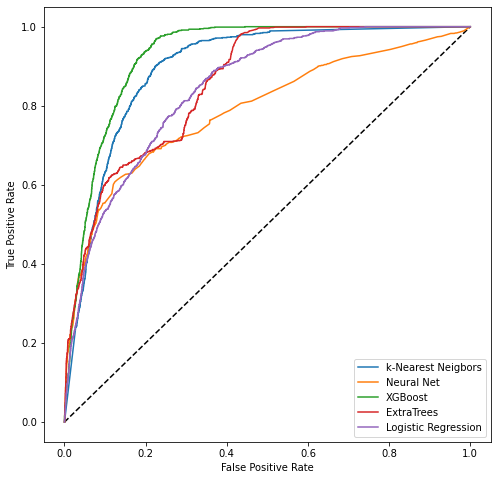

In [60]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_y_proba[:,1])
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, mlp_y_proba[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_y_proba[:,1])
fpr_etc, tpr_etc, thresholds_etc = roc_curve(y_test, etc_y_proba[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_y_proba[:,1])

plt.figure(figsize = (8, 8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_knn, tpr_knn, label = 'k-Nearest Neigbors')
plt.plot(fpr_mlp, tpr_mlp, label = 'Neural Net')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost')
plt.plot(fpr_etc, tpr_etc, label = 'ExtraTrees')
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Gain and Lift Charts for Selected Models

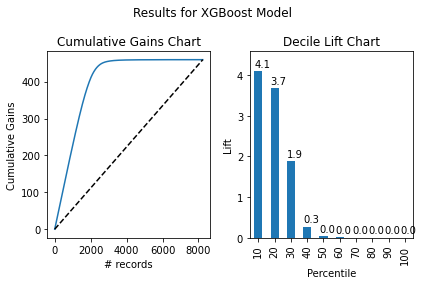

In [54]:
neg, pos = zip(*xgb_y_proba)
xg_probs = pd.Series(pos)
xg_probs_adj = xg_probs * (11.52/50)
xg_probs_sort = xg_probs_adj.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(xg_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(xg_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for XGBoost Model")
plt.tight_layout()
plt.show()

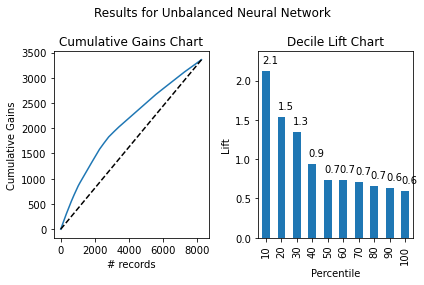

In [57]:
neg, pos = zip(*mlp_y_proba)
nnet_probs = pd.Series(pos)
nnet_probs_sort = nnet_probs.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(nnet_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(nnet_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for Neural Network")
plt.tight_layout()
plt.show()

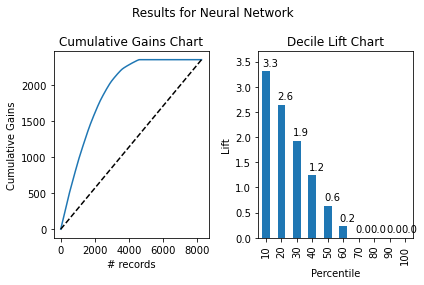

In [58]:
neg, pos = zip(*knn_y_proba)
knn_probs = pd.Series(pos)
knn_probs_sort = knn_probs.sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2)
ax = gainsChart(knn_probs_sort, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(knn_probs_sort, ax = axes[1], labelBars = True)
ax.set_ylabel('Lift')

plt.suptitle("Results for Neural Network")
plt.tight_layout()
plt.show()

#### Archived Experimental Accuracy Plots

<Figure size 432x288 with 0 Axes>

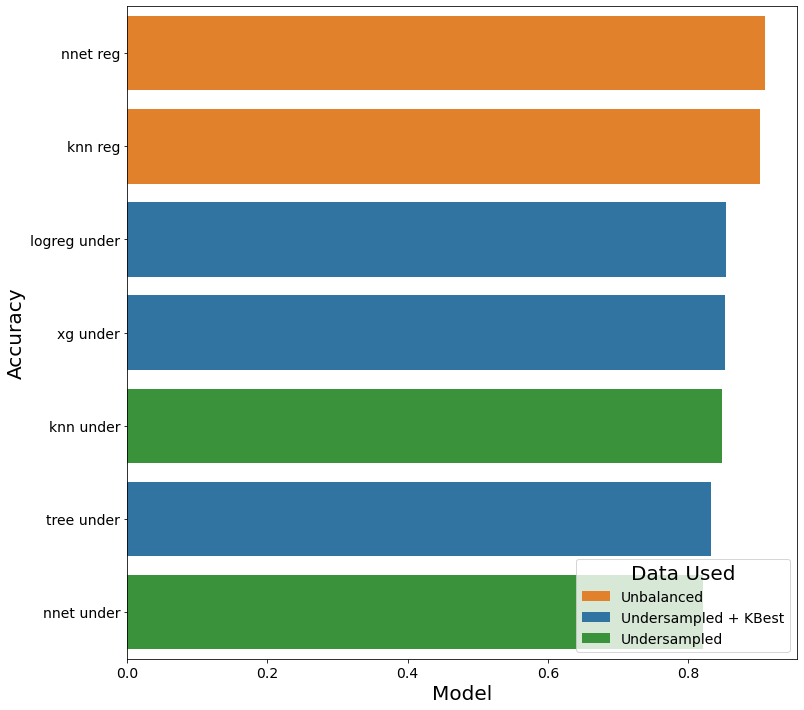

In [118]:
Results_acc = Results_saved.sort_values(by=['Accuracy'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotac = sns.barplot(y = 'Model', x = 'Accuracy', hue = 'Data Used', data = Results_acc, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('Accuracy',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
legend = plt.legend(loc = 'lower right', title = 'Data Used', fontsize = 14)
plt.setp(legend.get_title(), fontsize = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

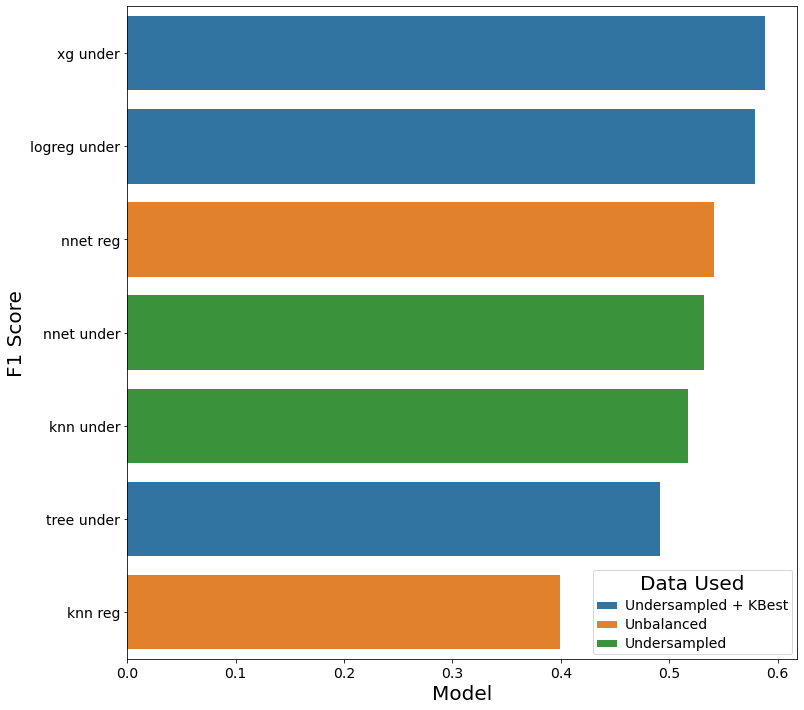

In [119]:
Results_f1 = Results_saved.sort_values(by=['F1 Score'], ascending=False)
plt.clf()
plt.figure(figsize=[12,12])
plotf1 = sns.barplot(y = 'Model', x = 'F1 Score', hue = 'Data Used', data = Results_f1, dodge=False,
            palette = {'Unbalanced' : 'tab:orange', 'Undersampled': 'tab:green', 'Undersampled + KBest': 'tab:blue',})
plt.xlabel('Model',fontsize = 20)
plt.ylabel('F1 Score',fontsize =20)
plt.xticks(fontsize =14)
plt.yticks(fontsize = 14)
plt.setp(plotf1.get_legend().get_texts(), fontsize = 14)
plt.setp(plotf1.get_legend().get_title(), fontsize = 20)
plt.show()